In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [302]:
data = pd.read_csv('data/Average Temperature 1900-2023.csv')

data.head()

,Year,Average_Fahrenheit_Temperature
0,1900,53.9
1,1901,53.5
2,1902,52.1
3,1903,50.6
4,1904,51.8


In [303]:
# convert fahrenheit to celsius
data['Temperature_Celsius'] = round((data['Average_Fahrenheit_Temperature'] - 32) * 5/9,2)

data = data.drop(columns=['Average_Fahrenheit_Temperature'])
data.head()

,Year,Temperature_Celsius
0,1900,12.17
1,1901,11.94
2,1902,11.17
3,1903,10.33
4,1904,11.00


In [304]:
data.shape

(124, 2)

In [305]:
data.describe()

,Year,Temperature_Celsius
count,124.000000,124.000000
mean,1961.500000,11.257177
std,35.939764,0.851879
min,1900.000000,9.000000
25%,1930.750000,10.655000
50%,1961.500000,11.220000
75%,1992.250000,11.940000
max,2023.000000,12.940000


In [306]:
data.isnull().sum()

Year                   0
Temperature_Celsius    0
dtype: int64

In [307]:
# average temperature in celsius
average_temp = data['Temperature_Celsius'].mean()
average_temp

11.25717741935484

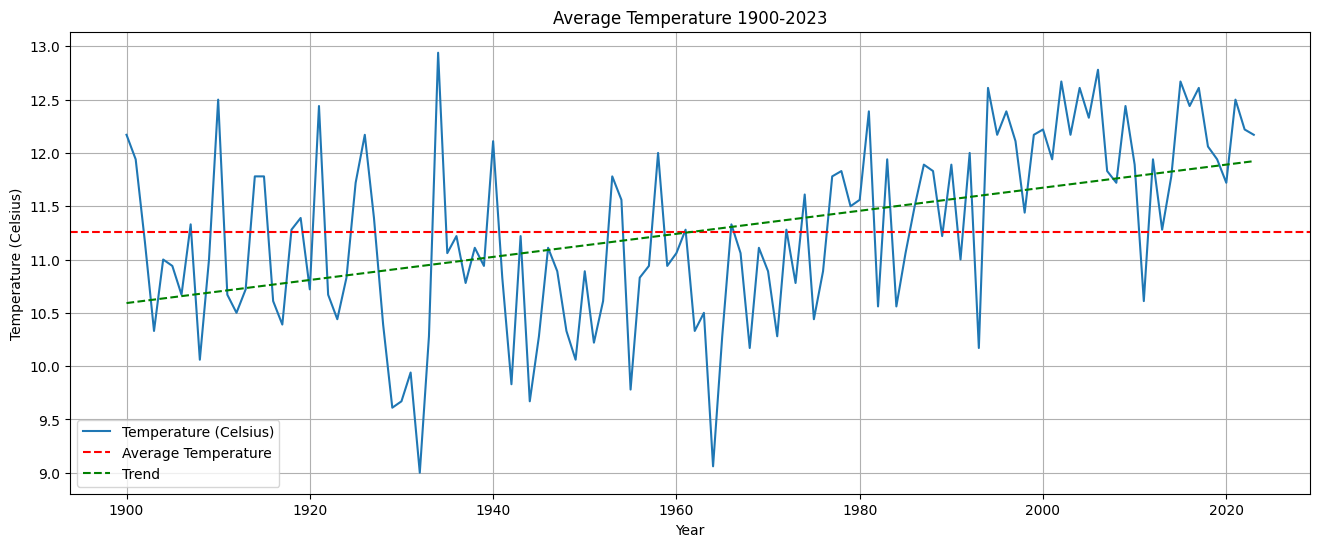

In [308]:
# plot the data
plt.figure(figsize=(16,6))
plt.plot(data['Year'], data['Temperature_Celsius'])
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Average Temperature 1900-2023')

plt.grid(True)
# show ab line
plt.axhline(y=average_temp, color='r', linestyle='--')
# Trend line
z = np.polyfit(data['Year'], data['Temperature_Celsius'], 1)
p = np.poly1d(z)
plt.plot(data['Year'],p(data['Year']),'g--')
plt.legend(['Temperature (Celsius)', 'Average Temperature', 'Trend'])
plt.show()

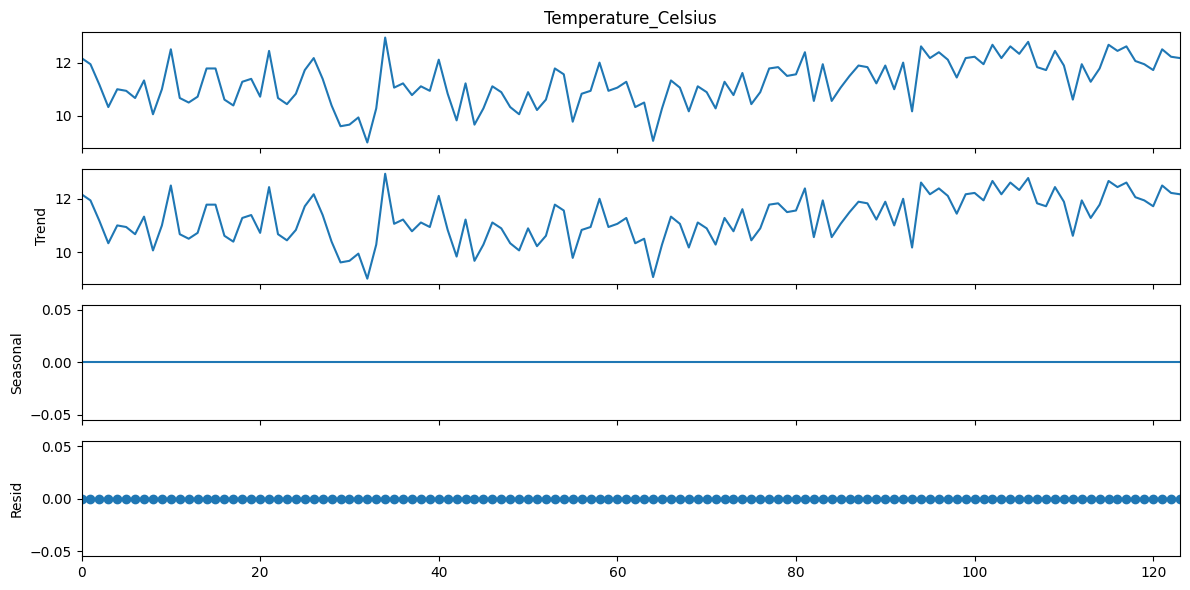

In [309]:
# let's see data seasonality, trend and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Temperature_Celsius'], model='additive', period=1)
result.plot()
plt.rcParams.update({'figure.figsize': (12,6)})
plt.show()

In [310]:
# Looking at the data it's clear that data is not stationary, we will use Dickey-Fuller test to confirm it
from statsmodels.tsa.stattools import adfuller

print ('Dickey-Fuller Test:')
dftest = adfuller(data['Temperature_Celsius'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

# p-value is greater than critital value of 5%, so we can't reject the null hypothesis, which means data is non-stationary.

Dickey-Fuller Test:
Test Statistic                  -4.828718
p-value                          0.000048
#Lags Used                       1.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


In [312]:
# fix the non-stationarity using log transformation
data['Temperature_Celsius_Log'] = np.log(data['Temperature_Celsius'])

data.head()

,Year,Temperature_Celsius,Temperature_Celsius_Log
0,1900,12.17,2.498974
1,1901,11.94,2.479894
2,1902,11.17,2.413232
3,1903,10.33,2.335052
4,1904,11.00,2.397895


In [313]:
# auto arima model
from pmdarima import auto_arima

stepwise_model = auto_arima(data['Temperature_Celsius_Log'], start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

stepwise_model.summary()

# split the data into train and test
train = data.iloc[:len(data)-10]
test = data.iloc[len(data)-10:]

# fit the model
stepwise_model.fit(train['Temperature_Celsius_Log'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-254.892, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-156.115, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-204.729, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-254.430, Time=0.19 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-206.068, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-253.237, Time=0.64 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-231.283, Time=0.37 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-252.931, Time=0.74 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-252.921, Time=0.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-254.698, Time=0.38 sec
 ARIMA(2,1,0)(0,1,1)[12]             : 

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [314]:
# forecast
forecast_test = stepwise_model.predict(n_periods=10)

In [315]:
# calculate the error
from sklearn.metrics import mean_squared_error

error = np.sqrt(mean_squared_error(test['Temperature_Celsius_Log'], forecast_test))
print('RMSE:', error)

RMSE: 0.04178957229918085


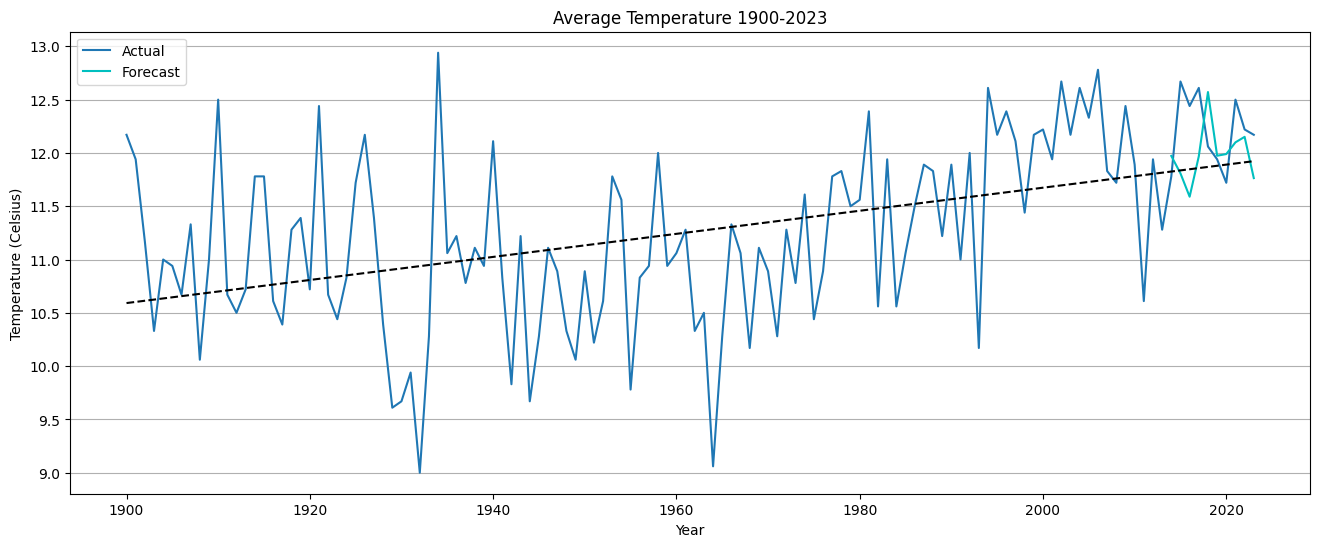

In [316]:
# reverse the log transformation
forecast_test = np.exp(forecast_test)

# plot the forecast
plt.figure(figsize=(16,6))
plt.plot(data['Year'], data['Temperature_Celsius'], label='Actual')
plt.plot(test['Year'], forecast_test, label='Forecast', color='c')
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Average Temperature 1900-2023')
# Trend line
z = np.polyfit(data['Year'], data['Temperature_Celsius'], 1)
p = np.poly1d(z)
plt.plot(data['Year'],p(data['Year']),'k--')
plt.grid(True, axis='y')
plt.legend(loc='upper left')
plt.show()

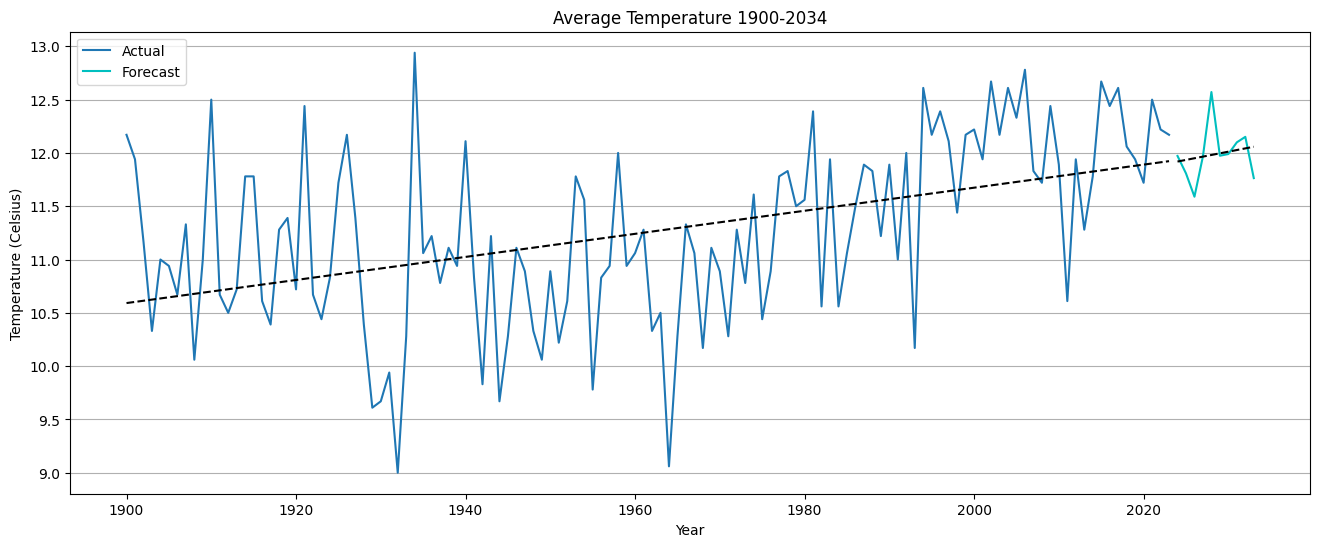

In [317]:
# forecast for next 10 years
future_forecast_ten = stepwise_model.predict(n_periods=10)

# reverse the log transformation
future_forecast_ten = np.exp(future_forecast_ten)

# plot the forecast
plt.figure(figsize=(16,6))
plt.plot(data['Year'], data['Temperature_Celsius'], label='Actual')
plt.plot(range(2024,2034), future_forecast_ten, label='Forecast', color='c')
# Trend line
z = np.polyfit(data['Year'], data['Temperature_Celsius'], 1)
p = np.poly1d(z)
plt.plot(data['Year'],p(data['Year']),'k--')
# Trend line for forecast
z = np.polyfit(range(2024,2034), future_forecast_ten, 1)
p = np.poly1d(z)
plt.plot(range(2024,2034),p(range(2024,2034)),'k--')

plt.grid(True, axis='y')
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Average Temperature 1900-2034')
plt.legend(loc='upper left')
plt.show()

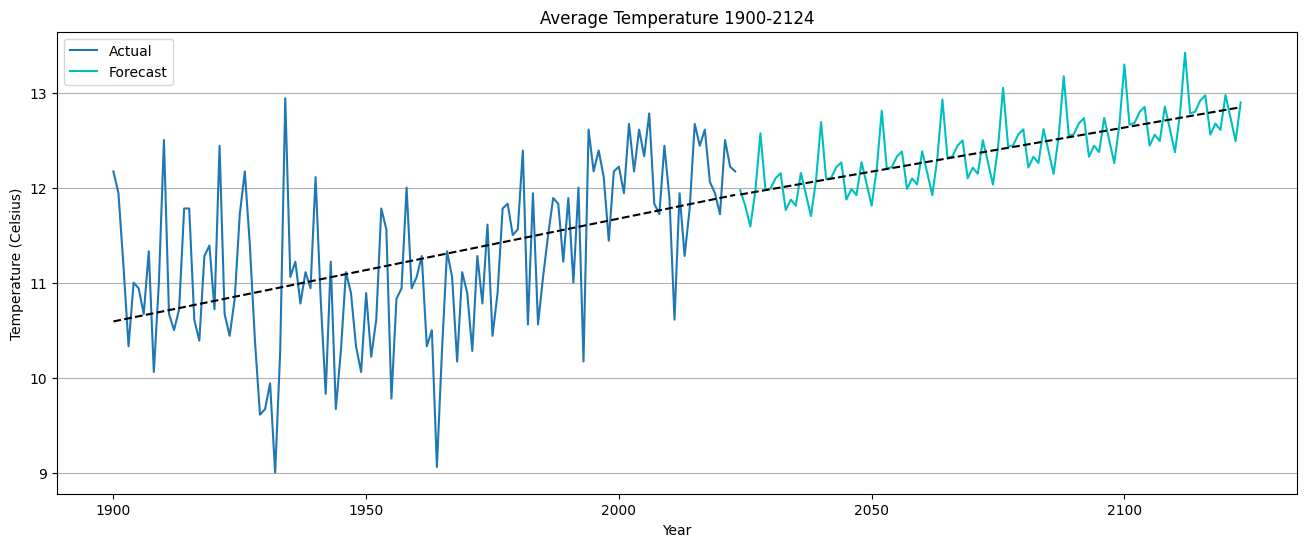

In [318]:
# forecast for next 100 years
future_forecast_hundred = stepwise_model.predict(n_periods=100)

# reverse the transformation
future_forecast_hundred = np.exp(future_forecast_hundred)

# plot the forecast
plt.figure(figsize=(16,6))
plt.plot(data['Year'], data['Temperature_Celsius'], label='Actual')
plt.plot(range(2024,2124), future_forecast_hundred, label='Forecast', color='c')
plt.grid(True, axis='y')
# Trend line
z = np.polyfit(data['Year'], data['Temperature_Celsius'], 1)
p = np.poly1d(z)
plt.plot(data['Year'],p(data['Year']),'k--')
# trend line forecast
z = np.polyfit(range(2024,2124), future_forecast_hundred, 1)
p = np.poly1d(z)
plt.plot(range(2024,2124),p(range(2024,2124)),'k--')
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Average Temperature 1900-2124')
plt.legend()
plt.show()